In [1]:
import json
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis

sys.path.insert(0, "../")
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


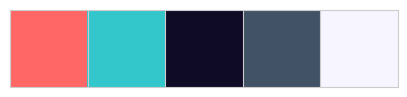

In [17]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [2]:
def get_subgroup_metrcs(_preds, _pert_data):

    pert_cat = _preds["pert_cat"]
    true = _preds["truth"]
    pred = _preds["pred"]

    ctrl_adata = _pert_data.adata[_pert_data.adata.obs["condition"] == "ctrl"]
    mean_ctrl = np.array(ctrl_adata.X.mean(0)).flatten() 

    pert_res = {}

    for _pert, _true, _pred in zip(pert_cat, true, pred):
        myr = pearsonr(_true - mean_ctrl, _pred - mean_ctrl)[0]

        pert_res[_pert] = myr

    test_subgroup = _pert_data.subgroup["test_subgroup"]
    subgroup_analysis = {}
    for name in test_subgroup.keys():
        subgroup_analysis[name] = []

    from collections import defaultdict
    category_cnt = defaultdict(int)

    for k, v in pert_res.items():
        for category, cat_pert in test_subgroup.items():
            if k in cat_pert:
                subgroup_analysis[category].append(v)
                category_cnt[category] += 1

    print(category_cnt)

    for k, v in subgroup_analysis.items():
        subgroup_analysis[k] = np.mean(v)
    
    return subgroup_analysis

In [3]:
pert_data = PertData("./data")
pert_data.load(data_name="norman")
pert_data.prepare_split(split="simulation", seed=1)

Found local copy...


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [ ]:
test_preds_scgpt = np.load("./save/dev_perturb_norman-Sep24-13-29/test_res_best_model.npz")
test_preds_scgpt = {k: v for k, v in test_preds_scgpt.items()}

test_preds_scfound = np.load("../scFoundation/GEARS/results/norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27/test_res_best_model.npz")

# bulk models
bulk_model_base_dir = Path("./save/norman")

test_pred_mean = np.load(bulk_model_base_dir / "mean/test_res_best_model.npz", allow_pickle=True)

test_preds_rf_go = np.load(bulk_model_base_dir / "RF/go/test_res_best_model.npz", allow_pickle=True)
test_preds_rf_go = {k: v for k, v in test_preds_rf_go.items()}

test_preds_rf_elmo = np.load(bulk_model_base_dir / "RF/elmo/test_res_best_model.npz", allow_pickle=True)
test_preds_rf_elmo = {k: v for k, v in test_preds_rf_elmo.items()}

test_preds_rf_found = np.load(bulk_model_base_dir / "RF/foundation/test_res_best_model.npz", allow_pickle=True)
test_preds_rf_found = {k: v for k, v in test_preds_rf_found.items()}

test_preds_rf_gpt = np.load(bulk_model_base_dir / "RF/gpt/test_res_best_model.npz", allow_pickle=True)
test_preds_rf_gpt = {k: v for k, v in test_preds_rf_gpt.items()}

In [7]:
scgpt_metrics = get_subgroup_metrcs(test_preds_scgpt, pert_data)
scfound_metrics = get_subgroup_metrcs(test_preds_scfound, pert_data)

# bulk model
mean_metrics = get_subgroup_metrcs(test_pred_mean, pert_data)
rf_go_metrics = get_subgroup_metrcs(test_preds_rf_go, pert_data)
rf_elmo_metrics = get_subgroup_metrcs(test_preds_rf_elmo, pert_data)
rf_found_metrics = get_subgroup_metrcs(test_preds_rf_found, pert_data)
rf_gpt_metrics = get_subgroup_metrcs(test_preds_rf_gpt, pert_data)

defaultdict(<class 'int'>, {'combo_seen2': 18, 'unseen_single': 37, 'combo_seen1': 52, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 9, 'unseen_single': 23, 'combo_seen1': 37, 'combo_seen0': 8})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})
defaultdict(<class 'int'>, {'combo_seen2': 18, 'combo_seen1': 52, 'unseen_single': 37, 'combo_seen0': 9})


In [11]:
res_df = pd.DataFrame(
    [
        scgpt_metrics,
        scfound_metrics,
        mean_metrics,
        rf_go_metrics,
        rf_elmo_metrics,
        rf_found_metrics,
        rf_gpt_metrics,
    ],
    index=[
        "scGPT",
        "scFoundation",
        "mean",
        "RF_go",
        "RF_scElmo",
        "RF_scFound",
        "RF_scGPT"])

In [15]:
# res_df to long format
myout = res_df.stack().reset_index().rename(columns={"level_0": "model", "level_1": "subgroup", 0: "pearson_delta"})

In [23]:
hue_colors = {
    "combo_seen0": "#FF6666",
    "combo_seen1": "#0F0A26",
    "combo_seen2": "#425266",
    "unseen_single": "#33C7CC"
}

Text(0.5, 1.0, 'Norman')

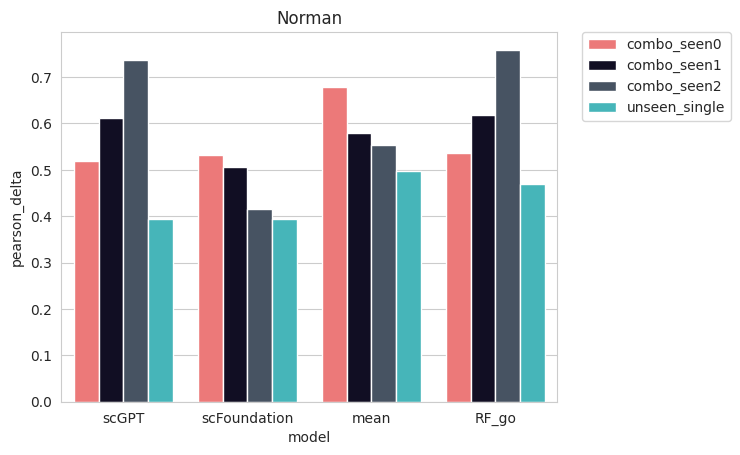

In [ ]:
first_models = ["scGPT", "scFoundation", "mean", "RF_go"]
second_models = ["RF_go", "RF_scElmo", "RF_scFoundation", "RF_scGPT"]

myfirst = myout[myout["model"].isin(first_models)]
mysecond = myout[myout["model"].isin(second_models)]

sns.barplot(data=myfirst, x="model", y="pearson_delta", hue="subgroup", order=first_models, palette=hue_colors)

# set legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Norman")

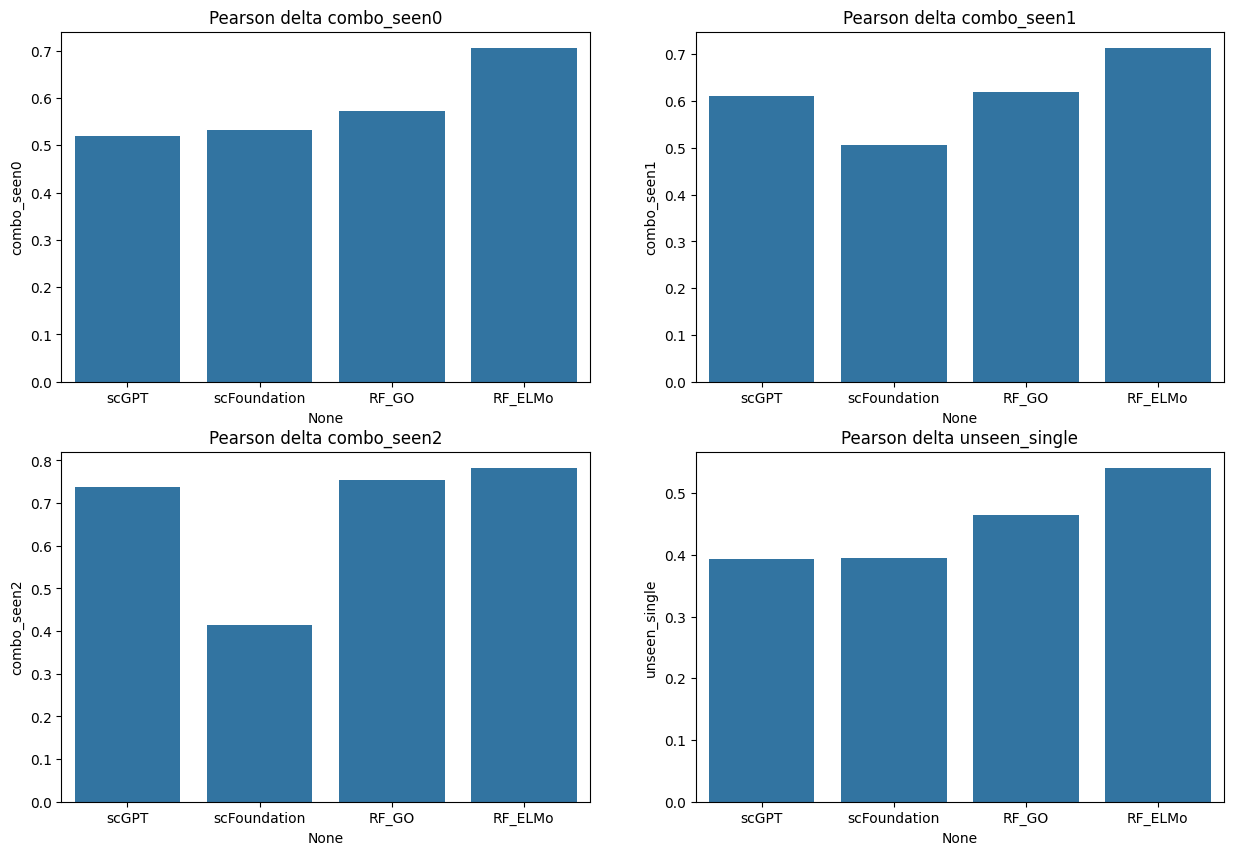

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

flattened_axs = axs.flatten()

for idx, col in enumerate(res_df.columns):
    ax = flattened_axs[idx]
    sns.barplot(x=res_df.index, y=res_df[col], ax=ax)
    ax.set_title(f"Pearson delta {col}")

In [55]:
import pandas as pd
df = pd.read_csv("./save/norman/RF/go/predictions.csv")

In [56]:
df

,condition,ENSG00000239945,ENSG00000223764,ENSG00000187634,ENSG00000187642,ENSG00000188290,ENSG00000187608,ENSG00000273443,ENSG00000237330,ENSG00000223823,...,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727,ENSG00000273554,ENSG00000278633
0,CEBPE+RUNX1T1,0.000075,0.008868,0.018128,0.000358,0.178323,0.320542,0.000016,0.007699,0.000000,...,4.115071,5.201456,3.588993,1.170180,4.525203,2.120916,1.352351,3.752850,0.000900,0.000017
1,CBL+PTPN9,0.000205,0.005376,0.015700,0.000689,0.160961,0.331846,0.000104,0.002771,0.000000,...,4.045303,5.135014,3.562104,1.090122,4.453604,2.053278,1.292294,3.710027,0.001157,0.000122
2,DUSP9+ctrl,0.000114,0.004205,0.012144,0.000255,0.202756,0.317101,0.000017,0.009495,0.000017,...,4.077724,5.163596,3.536564,1.182437,4.502628,2.119585,1.465095,3.717099,0.001355,0.000070
3,MAP2K6+SPI1,0.000127,0.003790,0.011648,0.000564,0.183577,0.330398,0.000047,0.002229,0.000017,...,3.987768,5.073945,3.505652,1.043616,4.386294,1.994351,1.291349,3.658145,0.001056,0.000000
4,UBASH3B+PTPN12,0.000181,0.002954,0.009751,0.000132,0.212981,0.313198,0.000000,0.013623,0.000000,...,4.053455,5.162208,3.532491,1.138649,4.471172,2.114337,1.418602,3.713042,0.001065,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CBL+UBASH3A,0.000172,0.004605,0.013641,0.000598,0.149488,0.328507,0.000092,0.002706,0.000000,...,4.016509,5.104601,3.553210,1.060738,4.426282,2.019878,1.239557,3.706777,0.001283,0.000070
112,CDKN1C+ctrl,0.000098,0.004409,0.013290,0.000479,0.207653,0.321275,0.000032,0.014395,0.000017,...,4.046443,5.142325,3.519057,1.120868,4.464744,2.081813,1.358539,3.691871,0.001168,0.000017
113,ctrl+CDKN1B,0.000081,0.004554,0.012820,0.000410,0.182344,0.321788,0.000067,0.012564,0.000000,...,4.017861,5.101797,3.513058,1.089310,4.425679,2.034107,1.300444,3.668999,0.000977,0.000035
114,CDKN1B+CDKN1A,0.000085,0.005955,0.016032,0.000337,0.180804,0.320883,0.000085,0.008195,0.000050,...,4.010535,5.109020,3.505219,1.070176,4.407324,2.029180,1.294777,3.656933,0.000848,0.000140


In [68]:
df["condition"].values

array(['CEBPE+RUNX1T1', 'CBL+PTPN9', 'DUSP9+ctrl', 'MAP2K6+SPI1',
       'UBASH3B+PTPN12', 'BCORL1+ctrl', 'CBL+ctrl', 'ctrl+SET',
       'TBX3+TBX2', 'DUSP9+MAPK1', 'COL2A1+ctrl', 'DUSP9+ETS2',
       'ZNF318+FOXL2', 'SET+CEBPE', 'UBASH3B+PTPN9', 'RHOXF2BB+ctrl',
       'POU3F2+ctrl', 'LYL1+IER5L', 'IGDCC3+MAPK1', 'CELF2+ctrl',
       'ZC3HAV1+CEBPE', 'CDKN1A+ctrl', 'MAPK1+PRTG', 'PTPN1+ctrl',
       'PTPN12+ctrl', 'ctrl+MAP7D1', 'KLF1+COL2A1', 'PTPN12+OSR2',
       'BPGM+SAMD1', 'POU3F2+FOXL2', 'DUSP9+PRTG', 'CKS1B+ctrl',
       'BCL2L11+TGFBR2', 'AHR+KLF1', 'CEBPB+CEBPA', 'PTPN12+UBASH3A',
       'FEV+MAP7D1', 'PLK4+ctrl', 'BPGM+ctrl', 'ETS2+CNN1',
       'C3orf72+ctrl', 'CNN1+MAPK1', 'FOXL2+MEIS1', 'FOXL2+ctrl',
       'PTPN12+PTPN9', 'FOSB+CEBPB', 'MAP7D1+ctrl', 'ctrl+CDKN1A',
       'SET+KLF1', 'PTPN12+SNAI1', 'BCL2L11+BAK1', 'CNN1+UBASH3A',
       'ISL2+ctrl', 'SAMD1+ZBTB1', 'IRF1+SET', 'ARID1A+ctrl', 'NCL+ctrl',
       'ctrl+COL2A1', 'ZC3HAV1+HOXC13', 'CBL+CNN1', 'ZBTB10+PTPN12'

In [61]:
test_preds_scgpt["pert_cat"].shape

(116,)

In [ ]:
from collections import defaultdict

mytest = defaultdict(list)

mytest["a"].append(np.)

In [69]:
test_preds_scgpt.keys()

dict_keys(['pert_cat', 'pred', 'truth'])

In [65]:
mytest

defaultdict(list, {'a': [1]})

In [60]:
test_preds_scgpt.keys()

dict_keys(['pert_cat', 'pred', 'truth'])

In [53]:
subgroup_metrics

{'combo_seen0': 0.5187340583663683,
 'combo_seen1': 0.6108783264761386,
 'combo_seen2': 0.7374173518040296,
 'unseen_single': 0.39290316703869094}

In [ ]:

pert_cat = test_preds["pert_cat"]
true = test_preds["truth"]
pred = test_preds["pred"]

ctrl_adata = pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
mean_ctrl = np.array(ctrl_adata.X.mean(0)).flatten() 

pert_res = {}

for _pert, _true, _pred in zip(pert_cat, true, pred):
    myr = pearsonr(_true - mean_ctrl, _pred - mean_ctrl)[0]

    pert_res[_pert] = myr


In [35]:
pert_data.subgroup.keys()

dict_keys(['test_subgroup', 'val_subgroup'])

In [37]:
pert_data.subgroup["test_subgroup"].keys()

dict_keys(['combo_seen0', 'combo_seen1', 'combo_seen2', 'unseen_single'])

In [40]:
test_subgroup = pert_data.subgroup["test_subgroup"]

In [41]:
subgroup_analysis = {}
for name in test_subgroup.keys():
    subgroup_analysis[name] = []

In [45]:
for k, v in pert_res.items():
    for category, cat_pert in test_subgroup.items():
        if k in cat_pert:
            subgroup_analysis[category].append(v)

In [47]:
for k, v in subgroup_analysis.items():
    subgroup_analysis[k] = np.mean(v)
    print(k, subgroup_analysis[k])

combo_seen0 0.5187340583663683
combo_seen1 0.6108783264761386
combo_seen2 0.7374173518040296
unseen_single 0.39290316703869094


In [46]:
subgroup_analysis

{'combo_seen0': [0.5667845560237565,
  0.5306366387470454,
  0.5587640995018057,
  0.5623586660915909,
  0.618698787256555,
  0.32095776463421527,
  0.7189421839930945,
  0.24830755188824719,
  0.543156277161004],
 'combo_seen1': [0.14143162562848577,
  0.4299097240776927,
  0.7221274825804344,
  0.7429684177086644,
  0.7448154815863998,
  0.6985692668964669,
  0.6348721850108808,
  0.7244577137790523,
  0.6728745656637689,
  0.9427511142459906,
  0.7373734455806392,
  0.5771653335909592,
  0.798335192924232,
  0.6546898634983849,
  0.7833393361470731,
  0.5841984590589374,
  0.7743776502616219,
  0.707009416334683,
  0.47802906343248286,
  0.7791788279186963,
  0.6596182460702738,
  0.09090272258388543,
  0.8056754550186074,
  0.7971203647136854,
  0.6606780199670377,
  0.10304200195547425,
  0.6905788248949445,
  0.6889766599112097,
  0.6494914680488915,
  0.7325560481397786,
  0.6625644168506161,
  0.4998915115005702,
  0.7202860549356975,
  0.4862556072571984,
  0.41947142034693086

In [44]:
test_subgroup

{'combo_seen0': ['POU3F2+FOXL2',
  'ZBTB10+PTPN12',
  'CEBPB+PTPN12',
  'CBL+PTPN12',
  'RHOXF2BB+SET',
  'CDKN1C+CDKN1B',
  'CDKN1C+CDKN1A',
  'CDKN1B+CDKN1A',
  'C3orf72+FOXL2'],
 'combo_seen1': ['CBL+PTPN9',
  'MAP2K6+SPI1',
  'UBASH3B+PTPN12',
  'DUSP9+MAPK1',
  'DUSP9+ETS2',
  'ZNF318+FOXL2',
  'SET+CEBPE',
  'KLF1+COL2A1',
  'PTPN12+OSR2',
  'BPGM+SAMD1',
  'DUSP9+PRTG',
  'BCL2L11+TGFBR2',
  'CEBPB+CEBPA',
  'PTPN12+UBASH3A',
  'FEV+MAP7D1',
  'FOXL2+MEIS1',
  'PTPN12+PTPN9',
  'FOSB+CEBPB',
  'SET+KLF1',
  'PTPN12+SNAI1',
  'BCL2L11+BAK1',
  'IRF1+SET',
  'CBL+CNN1',
  'CBL+UBASH3B',
  'CEBPB+MAPK1',
  'DUSP9+IGDCC3',
  'CEBPB+OSR2',
  'CEBPE+PTPN12',
  'DUSP9+KLF1',
  'FEV+ISL2',
  'POU3F2+CBFA2T3',
  'CEBPE+SPI1',
  'CBL+TGFBR2',
  'FOXA1+FOXL2',
  'ETS2+MAP7D1',
  'FOXF1+FOXL2',
  'LYL1+CEBPB',
  'PTPN12+ZBTB25',
  'DUSP9+SNAI1',
  'RHOXF2BB+ZBTB25',
  'FOSB+PTPN12',
  'SAMD1+PTPN12',
  'FOXL2+HOXB9',
  'ZBTB10+ELMSAN1',
  'JUN+CEBPB',
  'BPGM+ZBTB1',
  'ZBTB10+SNAI1',
  'CE

In [43]:
k

'AHR+KLF1'

In [ ]:
sub

In [28]:
_pert

'AHR+KLF1'

In [27]:
myr

PearsonRResult(statistic=0.7099318776038289, pvalue=0.0)

In [20]:
_pert

'AHR+KLF1'

In [21]:
_true

array([0.00000000e+00, 6.04944828e-03, 2.06960513e-03, ...,
       3.37998892e+00, 2.49300318e-03, 0.00000000e+00])

In [22]:
_pred

array([-3.82052753e-04,  2.16015951e-02,  1.28717164e-02, ...,
        3.24270000e+00,  2.07184356e-02,  2.07184356e-02])

In [23]:
mean_ctrl

array([0.0000000e+00, 3.0636375e-03, 7.3340833e-03, ..., 3.7373223e+00,
       8.7353901e-04, 0.0000000e+00], dtype=float32)

In [13]:
test_preds

{'pert_cat': array(['AHR+KLF1', 'ARID1A+ctrl', 'BCL2L11+BAK1', 'BCL2L11+TGFBR2',
        'BCL2L11+ctrl', 'BCORL1+ctrl', 'BPGM+SAMD1', 'BPGM+ZBTB1',
        'BPGM+ctrl', 'C3orf72+FOXL2', 'C3orf72+ctrl', 'CBL+CNN1',
        'CBL+PTPN12', 'CBL+PTPN9', 'CBL+TGFBR2', 'CBL+UBASH3A',
        'CBL+UBASH3B', 'CBL+ctrl', 'CDKN1A+ctrl', 'CDKN1B+CDKN1A',
        'CDKN1B+ctrl', 'CDKN1C+CDKN1A', 'CDKN1C+CDKN1B', 'CDKN1C+ctrl',
        'CEBPB+CEBPA', 'CEBPB+MAPK1', 'CEBPB+OSR2', 'CEBPB+PTPN12',
        'CEBPB+ctrl', 'CEBPE+CEBPB', 'CEBPE+PTPN12', 'CEBPE+RUNX1T1',
        'CEBPE+SPI1', 'CELF2+ctrl', 'CKS1B+ctrl', 'CNN1+MAPK1',
        'CNN1+UBASH3A', 'COL2A1+ctrl', 'DUSP9+ETS2', 'DUSP9+IGDCC3',
        'DUSP9+KLF1', 'DUSP9+MAPK1', 'DUSP9+PRTG', 'DUSP9+SNAI1',
        'DUSP9+ctrl', 'EGR1+ctrl', 'ETS2+CNN1', 'ETS2+IKZF3',
        'ETS2+MAP7D1', 'ETS2+MAPK1', 'FEV+ISL2', 'FEV+MAP7D1',
        'FOSB+CEBPB', 'FOSB+IKZF3', 'FOSB+PTPN12', 'FOSB+UBASH3B',
        'FOXA1+FOXL2', 'FOXA1+HOXB9', 'FOXA3+FOXL2', '

In [11]:
metrics = ["pearson_delta", "pearson_delta_de"]
metrics_non_dropout = [
    "pearson_delta_top20_de_non_dropout",
    "pearson_top20_de_non_dropout",
]

subgroup_analysis = {}
for name in pert_data.subgroup["test_subgroup"].keys():
    subgroup_analysis[name] = {}
    for m in metrics:
        subgroup_analysis[name][m] = []

    for m in metrics_non_dropout:
        subgroup_analysis[name][m] = []


In [12]:
subgroup_analysis

{'combo_seen0': {'pearson_delta': [],
  'pearson_delta_de': [],
  'pearson_delta_top20_de_non_dropout': [],
  'pearson_top20_de_non_dropout': []},
 'combo_seen1': {'pearson_delta': [],
  'pearson_delta_de': [],
  'pearson_delta_top20_de_non_dropout': [],
  'pearson_top20_de_non_dropout': []},
 'combo_seen2': {'pearson_delta': [],
  'pearson_delta_de': [],
  'pearson_delta_top20_de_non_dropout': [],
  'pearson_top20_de_non_dropout': []},
 'unseen_single': {'pearson_delta': [],
  'pearson_delta_de': [],
  'pearson_delta_top20_de_non_dropout': [],
  'pearson_top20_de_non_dropout': []}}

In [ ]:

for name, pert_list in pert_data.subgroup["test_subgroup"].items():
    for pert in pert_list:
        for m in metrics:
            subgroup_analysis[name][m].append(deeper_res[pert][m])

        for m in metrics_non_dropout:
            subgroup_analysis[name][m].append(non_dropout_res[pert][m])

for name, result in subgroup_analysis.items():
    for m in result.keys():
        mean_value = np.mean(subgroup_analysis[name][m])
        print("test_" + name + "_" + m + ": " + str(mean_value))

In [6]:
for k, v in test_preds.items():
    print(k, v.shape)

pert_cat (116,)
pred (116, 5045)
truth (116, 5045)
